In [98]:
import scipy.io
import numpy as np
import h5py
import xarray as xr
import matplotlib as plt
import pandas as pd

Read risk map

In [99]:
riskmap=xr.open_dataset('Riskmaps/320ktmig5aptnearstk_destriping_0_0075_amplitude_AGF_1_netcdf.nc').load()
riskmap.close()
riskmap=riskmap.assign_coords(X=riskmap.coordX)
riskmap=riskmap.assign_coords(Y=riskmap.coordY)

riskmap['prob']=riskmap.location_probability+0.001*riskmap.location_probability.sum()
riskmap['prob']=riskmap.prob/riskmap.prob.sum()
riskmap

<xarray.Dataset>
Dimensions:               (y: 193, x: 1289)
Coordinates:
    X                     (y, x) float32 5.678e+05 5.678e+05 ... 5.715e+05
    Y                     (y, x) float32 5.781e+06 5.781e+06 ... 5.783e+06
Dimensions without coordinates: y, x
Data variables:
    coordX                (y, x) float32 5.678e+05 5.678e+05 ... 5.715e+05
    coordY                (y, x) float32 5.781e+06 5.781e+06 ... 5.783e+06
    location_probability  (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    prob                  (y, x) float64 4.004e-06 4.004e-06 ... 4.004e-06

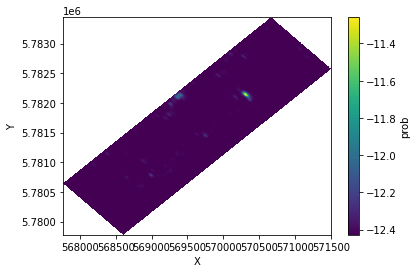

In [100]:
np.log(riskmap.prob).plot(x='X',y='Y')

Read foodprint 

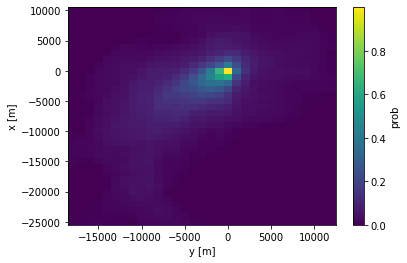

In [189]:
qq=xr.open_dataset('Original_Matlab/qq.nc').load()
qq.close()
qq.prob.plot()

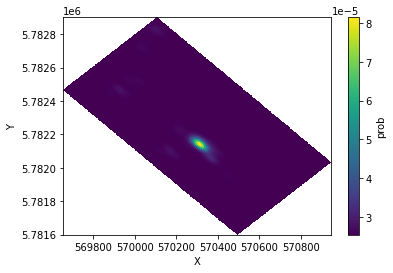

In [136]:

loc_map=riskmap.isel(x=840+np.arange(200))
loc_map['prob']=0.99*loc_map.prob/loc_map.prob.sum()
loc_map.prob.plot(x='X',y='Y')

In [137]:
loc_max=loc_map.prob.argmax(...)

In [143]:
pos=loc_map.isel(x=loc_max['x'],y=loc_max['y'])
pos

<xarray.Dataset>
Dimensions:               ()
Coordinates:
    X                     float32 5.703e+05
    Y                     float32 5.782e+06
Data variables:
    coordX                float32 5.703e+05
    coordY                float32 5.782e+06
    location_probability  float32 0.0009206
    prob                  float64 8.15e-05

In [191]:
qq

<xarray.Dataset>
Dimensions:  (x: 36, y: 31)
Coordinates:
  * x        (x) int64 -25000 -24000 -23000 -22000 ... 7000 8000 9000 10000
  * y        (y) int64 -18000 -17000 -16000 -15000 ... 9000 10000 11000 12000
Data variables:
    prob     (x, y) float64 0.001886 0.006762 0.006848 ... 0.002162 0.0 0.0

In [190]:
ql=qq.copy()
ql['X']=ql.x.values+pos.X.values
ql['Y']=ql.y.values+pos.Y.values
ql

<xarray.Dataset>
Dimensions:  (x: 36, y: 31, X: 36, Y: 31)
Coordinates:
  * x        (x) int64 -25000 -24000 -23000 -22000 ... 7000 8000 9000 10000
  * y        (y) int64 -18000 -17000 -16000 -15000 ... 9000 10000 11000 12000
  * X        (X) float64 5.453e+05 5.463e+05 5.473e+05 ... 5.793e+05 5.803e+05
  * Y        (Y) float64 5.764e+06 5.765e+06 5.766e+06 ... 5.793e+06 5.794e+06
Data variables:
    prob     (x, y) float64 0.001886 0.006762 0.006848 ... 0.002162 0.0 0.0

In [162]:
loc_map

<xarray.Dataset>
Dimensions:               (y: 193, x: 200)
Coordinates:
    X                     (y, x) float32 5.697e+05 5.697e+05 ... 5.709e+05
    Y                     (y, x) float32 5.782e+06 5.782e+06 ... 5.782e+06
Dimensions without coordinates: y, x
Data variables:
    coordX                (y, x) float32 5.697e+05 5.697e+05 ... 5.709e+05
    coordY                (y, x) float32 5.782e+06 5.782e+06 ... 5.782e+06
    location_probability  (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    prob                  (y, x) float64 2.533e-05 2.533e-05 ... 2.533e-05

In [164]:
ql

<xarray.Dataset>
Dimensions:  (x: 36, y: 31)
Coordinates:
  * x        (x) float64 5.453e+05 5.463e+05 5.473e+05 ... 5.793e+05 5.803e+05
  * y        (y) float64 5.764e+06 5.765e+06 5.766e+06 ... 5.793e+06 5.794e+06
    X        float32 5.703e+05
    Y        float32 5.782e+06
Data variables:
    prob     (x, y) float64 0.001886 0.006762 0.006848 ... 0.002162 0.0 0.0

In [165]:
ql.prob

<xarray.DataArray 'prob' (x: 36, y: 31)>
array([[0.001886, 0.006762, 0.006848, ..., 0.      , 0.      , 0.      ],
       [0.      , 0.006057, 0.006391, ..., 0.      , 0.      , 0.      ],
       [0.      , 0.002   , 0.002724, ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.005133, 0.003571, 0.001419],
       [0.      , 0.      , 0.      , ..., 0.003809, 0.002   , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.002162, 0.      , 0.      ]])
Coordinates:
  * x        (x) float64 5.453e+05 5.463e+05 5.473e+05 ... 5.793e+05 5.803e+05
  * y        (y) float64 5.764e+06 5.765e+06 5.766e+06 ... 5.793e+06 5.794e+06
    X        float32 5.703e+05
    Y        float32 5.782e+06

In [166]:
loc_map

<xarray.Dataset>
Dimensions:               (y: 193, x: 200)
Coordinates:
    X                     (y, x) float32 5.697e+05 5.697e+05 ... 5.709e+05
    Y                     (y, x) float32 5.782e+06 5.782e+06 ... 5.782e+06
Dimensions without coordinates: y, x
Data variables:
    coordX                (y, x) float32 5.697e+05 5.697e+05 ... 5.709e+05
    coordY                (y, x) float32 5.782e+06 5.782e+06 ... 5.782e+06
    location_probability  (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    prob                  (y, x) float64 2.533e-05 2.533e-05 ... 2.533e-05

In [197]:
ql.prob.interp_like(loc_map)

ValueError: different size for unlabeled dimension on argument 'y': 193 vs 31